### Compares LGARTO (C) real examples against Hydrus
### Date: 14 August, 2023 (last updated)
### By Ahmad Jan and Peter La Follette

#### Make sure to update/provide the correct local paths. 

In [164]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
import importlib as imp
import copy
import pandas as pd
import datetime as dt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

import pickle

In [165]:
# C version
sim_case = '/Users/peterlafollette/Desktop/merge_LGARTO_and_LGAR/LGAR-C/data_variables.csv' 
# sim_case = '/Users/peterlafollette/Desktop/ngen_test_2/ngen/extern/LGARTO-C/LGARTO_outputs/data_variables_Koptis_Farms.csv' 
c_path_vars = sim_case

outfile = "/Users/peterlafollette/Desktop/merge_LGARTO_and_LGAR/LGAR-C/tests/c-hydrus-comparison_Koptis_Farms.png"

save_outfile = True

In [166]:
# num_steps = 3000
    
# start = pd.Timestamp("2020-10-01 00:00:00")
# end = pd.Timestamp("2021-02-03 00:00:00")
# times = pd.date_range(start=start,end=end, periods=num_steps) #freq='min'
# times_bmi = pd.date_range(start=start,end=end, periods=num_steps)

# xfmt = mdates.DateFormatter('%Y/%m/%d')


In [167]:
num_steps = 8760
    
start = pd.Timestamp("2020-10-01 00:00:00")
end = pd.Timestamp("2021-10-01 00:00:00")
times = pd.date_range(start=start,end=end, periods=num_steps) #freq='min'
times_bmi = pd.date_range(start=start,end=end, periods=num_steps)

xfmt = mdates.DateFormatter('%Y/%m/%d')


In [168]:
data_c_vars = pd.read_csv(c_path_vars)
data_c_vars = data_c_vars[0:num_steps]
data_c_vars.head()

,Time,precipitation,potential_evapotranspiration,actual_evapotranspiration,surface_runoff,giuh_runoff,soil_storage,total_discharge,infiltration,percolation,groundwater_to_stream_recharge,mass_balance
0,2020-10-01 00:00:00,0.0,1.309684e-07,9.783017e-08,0.0,0.0,0.472829,0.0,0.0,0.000000e+00,0.0,-0.0
1,2020-10-01 01:00:00,0.0,1.971222e-07,1.472452e-07,0.0,0.0,0.472829,0.0,0.0,-1.422700e-11,0.0,0.0
2,2020-10-01 02:00:00,0.0,2.266905e-07,1.693315e-07,0.0,0.0,0.472829,0.0,0.0,-3.563800e-11,0.0,0.0
3,2020-10-01 03:00:00,0.0,1.064541e-07,7.951807e-08,0.0,0.0,0.472829,0.0,0.0,-6.025600e-11,0.0,-0.0
4,2020-10-01 04:00:00,0.0,7.709078e-08,5.758443e-08,0.0,0.0,0.472829,0.0,0.0,-7.180800e-11,0.0,0.0


In [169]:
m_to_mm = 1000


### Read Hydrus data

In [170]:
## Note: Hydrus output data is stored in LGAR-py repo, and the below path needs to be updated
#hyd_path = '/Users/ahmadjan/codes/side/lgar-py-dec15/LGAR-Py/HYDRUS_files/synthetic_test_1_HYDRUS/T_Level.txt'

# hyd_path = '/Users/peterlafollette/Desktop/ngen_test_2/ngen/extern/LGARTO-C/tests/HYDRUS_outputs/Geneva/T_Level.txt'
hyd_path = '/Users/peterlafollette/desktop/alt-modular_testing/alt-modular/Modules/LGARTO-C/tests/HYDRUS_outputs/Koptis_Farms/T_Level.txt'
# hyd_path = '/Users/peterlafollette/Desktop/ngen_test_2/ngen/extern/LGARTO-C/tests/HYDRUS_outputs/Mascoma_River/T_Level_more.txt'

HYDRUS_output = pd.read_fwf(hyd_path,widths=[13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13])            
HYDRUS_datetime_vec = []
i=0
prior_dt = dt.datetime.strptime(data_c_vars['Time'][0],'%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=HYDRUS_output['Time'][i]-1)
for i in range(0,len(HYDRUS_output['Time'])):
    current_dt = dt.datetime.strptime(data_c_vars['Time'][0],'%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=HYDRUS_output['Time'][i])
    if (current_dt!=prior_dt):
        HYDRUS_datetime_vec.append(current_dt)
    else:
        HYDRUS_output = HYDRUS_output.drop(i)
    prior_dt = current_dt
HYDRUS_output['HYDRUS_datetime_vec'] = HYDRUS_datetime_vec
HYDRUS_output = HYDRUS_output.set_index('HYDRUS_datetime_vec')

HYDRUS_output = HYDRUS_output.resample('3600s').pad()

HYDRUS_output.head()


,Time,rTop,rRoot,vTop,vRoot,vBot,sum(rTop,) sum(rRoot,) sum(vTop,) sum(vRoot,...,hRoot,hBot,RunOff,sum(RunOff,) Volume,sum(Infil,) sum(Evap,) TLevel Cum(,WTrans) Snow,Layer
HYDRUS_datetime_vec,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 01:00:00,1.0,0.0,0.000013,1.619600e-08,0.000010,0.000000e+00,0.0,0.000013,1.613900e-08,0.000010,...,-151.75,0.0,0.0,0.0,47.423,0.0,1.613900e-08,12 0.00,0.0,0.0
2020-10-01 02:00:00,2.0,0.0,0.000020,-2.150200e-08,0.000015,-2.178100e-08,0.0,0.000033,-5.270500e-09,0.000025,...,-151.75,0.0,0.0,0.0,47.423,0.0,1.613900e-08,24 0.00,0.0,0.0
2020-10-01 03:00:00,3.0,0.0,0.000023,5.226900e-08,0.000017,2.178100e-08,0.0,0.000055,-5.865500e-09,0.000042,...,-151.75,0.0,0.0,0.0,47.423,0.0,3.789700e-08,36 0.00,0.0,0.0
2020-10-01 04:00:00,4.0,0.0,0.000011,2.993500e-08,0.000008,-2.178100e-08,0.0,0.000066,3.156100e-08,0.000050,...,-151.75,0.0,0.0,0.0,47.423,0.0,7.532300e-08,48 0.00,0.0,0.0


0       0.000000e+00
1      -1.422700e-09
2      -4.986500e-09
3      -1.101210e-08
4      -1.819290e-08
            ...     
8755    4.794886e+01
8756    4.795971e+01
8757    4.797088e+01
8758    4.798203e+01
8759    4.799316e+01
Name: percolation, Length: 8760, dtype: float64


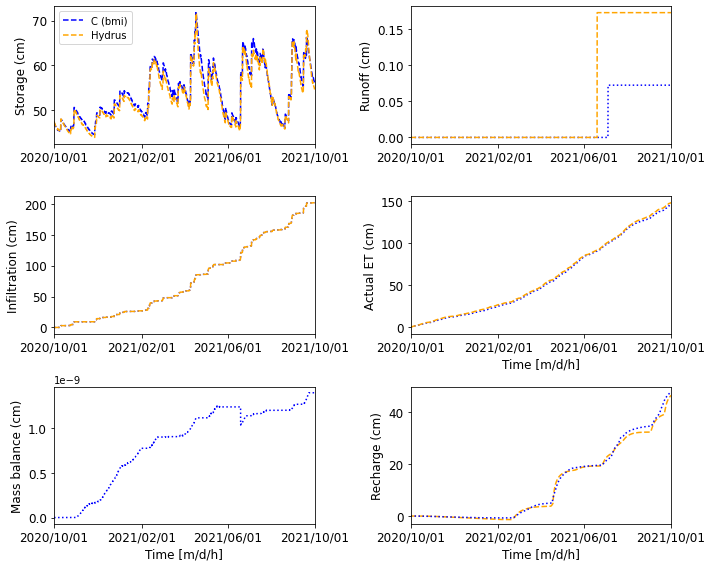

In [171]:
# end_step = 5950
# times_bmi = times_bmi[0:end_step]
# data_c_vars = data_c_vars [0:end_step]
# vars_hydrus = data_c_vars [0:end_step]
# HYDRUS_output = HYDRUS_output[0:end_step]






#%matplotlib qt
fig, axs = plt.subplots(3,2, figsize=(10,8), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

# vars_py = ['water_in_soil[mm]', 'runoff[mm/h]', 'actual_infil[mm/h]', 'actual_ET_per_step(mm)', 'mass_bal_error(mm)']
vars_bmi = ['soil_storage', 'surface_runoff', 'infiltration', 'actual_evapotranspiration', 'mass_balance', 'percolation']
vars_hydrus = [')     Volume', 'sum(RunOff', 'sum(Infil', ')   sum(vRoot', ')    sum(vBot']
m_to_mm = 1000
m_to_cm = 100
timestep = 300/3600
y_labels = ['Storage (cm)', 'Runoff (cm)', 'Infiltration (cm)', 'Actual ET (cm)', 'Mass balance (cm)', 'Recharge (cm)']

for i in range(len(y_labels)):
#     if i == 0 or i == 5:
    if i == 0:
        if i == 0:
#             axs[i].plot(data_py_vars[vars_py[i]],'r',label='Python')
            axs[i].plot(times_bmi, data_c_vars[vars_bmi[i]]*m_to_cm,'b',linestyle='dashed',label='C (bmi)')
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        else:
            ## plotting absolute difference between Hydrus vs LGAR-C and LGAR-Py
            hyd = []
            for t,v1 in zip(HYDRUS_output['Time'], HYDRUS_output[vars_hydrus[0]]):
                if t % 5.0 == 0:
                    hyd.append(v1)
            hyd_c_diff = []

            #hydrus output data does not include t=0 data
            for v2, v3 in zip(np.array(hyd),np.array(data_c_vars[vars_bmi[0]]*m_to_cm)[1:]):
                hyd_c_diff.append(abs(v2-v3))

#             hyd_py_diff = []
#             for v2, v3 in zip(np.array(hyd),np.array(data_py_vars[vars_py[0]])[1:]):
#                 hyd_py_diff.append(abs(v2-v3))
#             axs[i].plot(times_bmi[1:], hyd_py_diff,'g',linestyle='dashed',label='Hydrus - Py')

#             axs[i].plot(times_bmi[1:], hyd_c_diff,'c',linestyle='dashed',label='Hydrus - C')
            axs[i].legend()
        
    elif (i < len(vars_hydrus)-1):
        if i == 1 or i == 2 or i ==3 : 
#             axs[i].plot(np.cumsum(data_py_vars[vars_py[i]])*timestep,'r',label='Python')
            
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')  
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        if i==4:
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
            axs[4].axis(ymin=-1,ymax=1)
    elif (i==4):
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
#         axs[4].axis(ymin=-1,ymax=1)
        axs[5].plot(-1*HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        axs[5].axis(ymin=-3,ymax=50)
        print(np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm))
    else:
#         axs[i].plot(np.cumsum(data_py_vars[vars_py[i]]),'r',label='Python')
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'b',linestyle='dotted',label='C (bmi)')

            
    axs[i].set_ylabel(y_labels[i],fontsize=12)
    
    if i >2:
        axs[i].set_xlabel('Time [m/d/h]',fontsize=12)
    axs[i].tick_params(axis='x', labelsize=12,rotation=0)
    axs[i].tick_params(axis='y', labelsize=12,rotation=0)
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    
    axs[i].set_xlim(times_bmi[0], times_bmi[-1])
#axs[5].axis('OFF')
axs[0].legend()
plt.tight_layout()

if (save_outfile):
    plt.savefig(outfile,dpi=400)


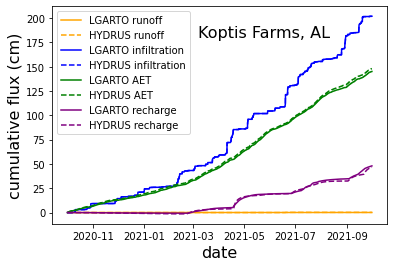

In [172]:

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[1]]*m_to_cm),'b',label='C (bmi)',color='orange')
plt.plot(HYDRUS_output[vars_hydrus[1]],'k',linestyle='dashed',label='Hydrus',color='orange')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[2]]*m_to_cm),'b',label='C (bmi)',color='blue')
plt.plot(HYDRUS_output[vars_hydrus[2]],'k',linestyle='dashed',label='Hydrus',color='blue')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[3]]*m_to_cm),'b',label='C (bmi)',color='green')
plt.plot(HYDRUS_output[vars_hydrus[3]],'k',linestyle='dashed',label='Hydrus',color='green')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm),'b',label='C (bmi)',color='purple')
plt.plot(-1*HYDRUS_output[vars_hydrus[4]],'k',linestyle='dashed',label='Hydrus',color='purple')

leg = plt.legend()#(handles=[runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS],labels=["LGARTO", "HYDRUS", "theta_e", "capillary head = -depth"])

mylabels = ['LGARTO runoff','HYDRUS runoff','LGARTO infiltration','HYDRUS infiltration','LGARTO AET','HYDRUS AET','LGARTO recharge','HYDRUS recharge']

plt.legend(labels=mylabels)

plt.text(x=times_bmi[3750], y=180, s='Koptis Farms, AL', fontsize = 16)

outfile_summpary_plot = "/Users/peterlafollette/Desktop/merge_LGARTO_and_LGAR/LGAR-C/tests/c-hydrus-comparison_Koptis_Farms_summary.png"

# plt.vlines(times_bmi[5920], 0, 125, colors ="red")

plt.ylabel("cumulative flux (cm)",fontsize=16)
plt.xlabel("date",fontsize=16)


plt.savefig(outfile_summpary_plot,dpi=400)

Text(0.5, 0, 'date')

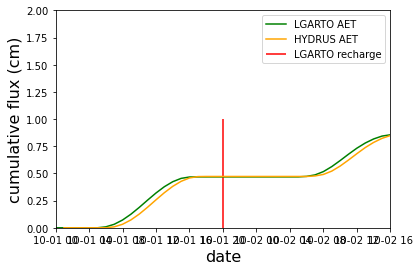

In [173]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

plt.xlim([times_bmi[0],times_bmi[40]])
plt.ylim([0,2])

plt.vlines(times_bmi[20], 0, 1, colors ="red")

# plt.text(x=times_bmi[4900], y=40, s='Kukuihaele, HI', fontsize = 16)

# plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[1]]*m_to_cm),'b',label='C (bmi)',color='orange')
# plt.plot(HYDRUS_output[vars_hydrus[1]],'k',linestyle='dashed',label='Hydrus',color='orange')

# plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[2]]*m_to_cm),'b',label='C (bmi)',color='blue')
# plt.plot(HYDRUS_output[vars_hydrus[2]],'k',linestyle='dashed',label='Hydrus',color='blue')

plt.plot(times_bmi[0:len(times_bmi)-0], np.cumsum(data_c_vars[vars_bmi[3]]*m_to_cm)[0:len(times_bmi)-0],'b',label='C (bmi)',color='green')
plt.plot(HYDRUS_output[vars_hydrus[3]][0:],'k',label='Hydrus',color='orange')

# plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm),'b',label='C (bmi)',color='purple')
# plt.plot(-1*HYDRUS_output[vars_hydrus[4]],'k',linestyle='dashed',label='Hydrus',color='purple')

leg = plt.legend()#(handles=[runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS],labels=["LGARTO", "HYDRUS", "theta_e", "capillary head = -depth"])

# mylabels = ['LGARTO runoff','HYDRUS runoff','LGARTO infiltration','HYDRUS infiltration','LGARTO AET','HYDRUS AET','LGARTO recharge','HYDRUS recharge']
mylabels = ['LGARTO AET','HYDRUS AET','LGARTO recharge','HYDRUS recharge']


# plt.legend(labels=mylabels, ncol=2)
plt.legend(labels=mylabels, ncol=1)

plt.ylabel("cumulative flux (cm)",fontsize=16)
plt.xlabel("date",fontsize=16)



# outfile_summpary_plot = "/Users/peterlafollette/Desktop/merge_LGARTO_and_LGAR/LGAR-C/tests/c-hydrus-comparison_Kukuihaele_summary.png"

# plt.savefig(outfile_summpary_plot,dpi=400)

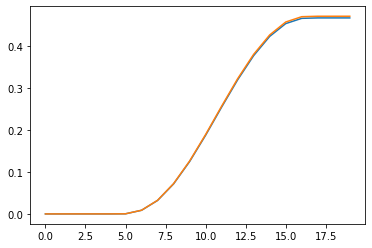

In [174]:
plt.plot(np.array(np.cumsum(data_c_vars[vars_bmi[3]]*m_to_cm)[0:20]))
plt.plot(np.array(HYDRUS_output[vars_hydrus[3]][1:21]))

In [175]:
np.array(HYDRUS_output[vars_hydrus[3]][1:])

array([9.9167e-06, 2.4837e-05, 4.1998e-05, ..., 1.4796e+02, 1.4796e+02,
       1.4796e+02])

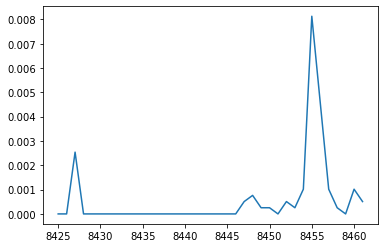

In [176]:
plt.plot(data_c_vars['precipitation'][8425:8462])

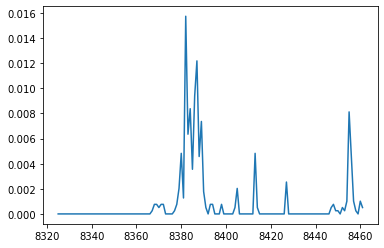

In [177]:
plt.plot(data_c_vars['precipitation'][8325:8462])

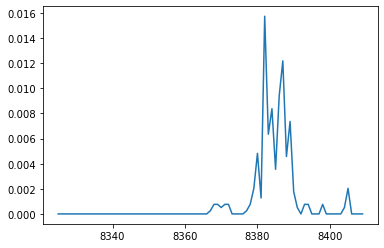

In [178]:
plt.plot(data_c_vars['precipitation'][8325:8410])

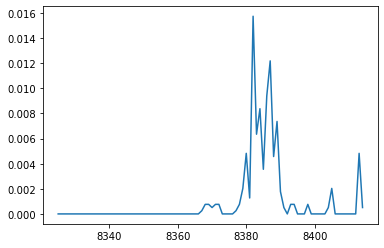

In [179]:
plt.plot(data_c_vars['precipitation'][8325:8415])

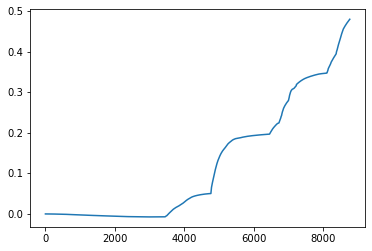

In [180]:
plt.plot(np.cumsum(data_c_vars['percolation'])[0:])

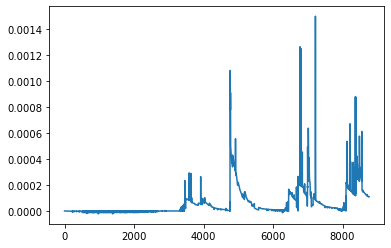

In [181]:
plt.plot(data_c_vars['percolation'])[0:]